In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
import warnings
from scipy import integrate # Cumulative trapezoidal integration
%matplotlib inline
warnings.filterwarnings('ignore')

# Snowball volcanoes

In [2]:
#Note that Budyko equation is written for temperature in celsius
#Note also that Budyko's original paper has radiation in units of kcal/cm2 each month ; we use W/m2
class budyko():
    """ energy balance climate model (Budyko style)"""
    
    def __init__(self, Q0=1336., s2=-0.482,T_s=-10., series = None):
        """ constructor
        PARAMETERS:
        Q0: float
            incoming solar radiation (Solar constant) units are W/m2
        s2: float
             coefficient for second order Legendre polynomial
        T_s: float
            critical temperature below which ice advances and shifts to alpha2 albedo

        """
        self.Q0 = Q0
        self.s2 = s2
        self.T_s = T_s
        self.i = 0
        self.series = series
        return None   

    def relative_distance(self, lat, re = 6378, strat_height = 18, strat_thick = 2):
        """
        Not used anymore because this affects calculation of planetary albedo in a non-linear fashion
        Function works, it takes as input the latitude, 
        and outputs the relative thickness of the aerosol layer relative to the aerosol layer at the equator. 
        
        Formulas are from https://rechneronline.de/pi/circular-layer.php
        
        PARAMETERS:
        lat: float
            latitude in degrees
        re: float
            radius of earth (km)
        strat_height
            stratosphere height above surface (km)
        strat_thick: float
            Thickness of the stratosphere layer (km)
        """

        # distance from height of circle
#         lat_radians = np.deg2rad(lat)
        res = re + strat_height
        j = res * (1-np.sin(lat))
        t1 = np.sqrt(2*res*j -j**2 )
        t1b  = res*np.cos(lat)
    #     assert(round(t1,2) == round(t1b, 2))
        resl = res + strat_thick
        jl = j + strat_thick
        t2 = np.sqrt(2 * resl * jl - jl**2)
        return (t2-t1)/strat_thick
    
    
    def get_qofx(self, A=211.1, B=1.55, C=3.74, alpha1=0.3,alpha2=0.6, tau =0, plotname = None):
        """ calculate the constant needed to solve for xs (sin ice line latitude) as a function of Q
          PARAMETERS:
        alpha_s: float
            albedo at ice line, taken to be average of alpha1 and alpha2     
        alpha1: float
            albedo in non-ice covered state
        alpha2: float
            albedo in ice-covered state
        tau: float
            optical depth due to 

         A: float
            Value taken from Lindzen & Farrell (1977); see Baker & Roe 2010  W/m2
          B: float
            Value taken from Lindzen & Farrell (1977); see Baker & Roe 2010  W/m2/C
            A+BT is the linear relationship between OLR and T; B reflects climate sensitivity
          C: float
            Value also taken from Lindzen & Farrell (1977). This term governs meridional redistribution of heat
            Units are W/m2/C; C(T(x)-Tavg); redistribution depends on difference of local T to global mean        
        """

        # Surface Albedo
        alpha_s = 0.5*(alpha1+alpha2) # Surface
        self.alpha_s = alpha_s
        self.alpha1 = alpha1
        self.alpha2 = alpha2

        # Parameters
        self.A = A
        self.B = B
        self.C = C
        
        #constant (see Roe & Baker 2010 Equation )
        k=self.A+(self.B*self.T_s)+(self.C*self.T_s)+((self.C*self.A)/self.B)
        self.k = k

        #Solve EBCM for Q as a function of x (sin(ice-line lattiude)
        #define array for x     
        x=np.linspace(0.,1.,num=1000)
        self.x = x # sin latitude
        
        # Stratospheric reflectance as a function of x
        # Tau = optical depth
        self.tau = tau
        
        # m = self.relative_distance(np.arcsin(x))
        # do i include it or not
        etau = np.exp(-tau) # e^tau
        self.etau = etau
        self.alpha_strat = 1-self.etau # Stratospheric albedo(x, tau)
        
        # Sx - simplifying the legendre Polynomial. 
        p1 = x
        p2 = 1/2*(3*x**2 - 1)
        p3 = 1/2*(5*x**3-3*x)
        Sx = self.s2*p2
        
        # Planetary albedo as a function of x
        
        # EDITED from original, split up into mutople variables
        s2 = self.s2
        p3term = ((-C*(alpha1-alpha2)*s2*x**3)/(8*B))
        c4balpha2 = ((C*alpha2)/(4*B))
        c4b1 = (C/(4*B))
        longterm = (((3*s2/8)*(1-alpha_s)*x**2)+(((C*(alpha1-alpha2))/(8*B))*(s2-2)*x)+(1/4)-(s2/8)-(alpha_s/4)+(alpha_s*s2)/8)
        Q=(k/(etau))/(p3term+longterm+c4b1-c4balpha2)
        self.Q=(self.k/(self.etau))/(p3term+longterm+c4b1-c4balpha2)
        self.Qrat=self.Q/self.Q0

        # Function gets the highest iceline equilibrium. 
        input_x,x_lat = self.get_iceline()
        
        # Post calculations
        a2 = self.alpha2
        a1 = self.alpha1
        s2 = self.s2
        p3 = .5* (5*input_x**3 - 3*input_x)
        p1 = input_x
        # Surface Albedo
        self.alpha_su =  a2 + (a1-a2)*(input_x + s2/5*(p3 - p1))
        # Total albedo
        self.alpha_p = self.alpha_su + self.alpha_strat - self.alpha_su*self.alpha_strat
        # Plot (not actually a timeseries)
        self.plot_timeserie_lat()

        # Count the iteration:
            # Each 'budyko' object can store multiple runs with different parameters. 
            # It will graph all runs run so far
            # Reset the graph by re-instantiating the budyko object. 
        self.i += 1
        return(self.x, self.Q, self.Qrat, self.Q0)

    def get_iceline(self):
        # If the Gsp is below 1, return the maximum of get roots
        if self.Qrat.min() < 1:
            iceline = self.x[len(self.Qrat)-1-np.argmax(self.Qrat[::-1]<1)]
            j = math.degrees(np.arcsin(iceline))
            return iceline,j
        # Otherwise, return 0
        return 0,0

    def get_roots(self):
        # Find roots: r1 is the coefficient for x^3; r2 for x^2; r1 for x, and r4 incorporates all constants
        r1 = -self.Q0*self.C*(self.alpha1-self.alpha2)*self.s2*(1/(8*self.B))
        r2 = ((3*self.Q0*self.s2)/8)*(1-self.alpha_s)
        r3 = ((self.Q0*self.C*(self.alpha1-self.alpha2))/(8*self.B))*(self.s2-2)
        r4 = (self.Q0/4)-((self.Q0*self.s2)/8)-((self.Q0*self.alpha_s)/4)+((self.Q0*self.etau*self.alpha_s*self.s2)/8)+((self.Q0*self.etau*self.C)/(4*self.B))-((self.Q0*self.etau*self.C*self.alpha2)/(4*self.B))-self.k        

        coeffs = [r1,r2,r3,r4]
        self.iceline = np.roots(coeffs)
#         print(self.iceline)
        #math.asin() returns in radians
        soln1=math.asin(self.iceline[1])
        soln2=math.asin(self.iceline[2])
#         print('Soln 1 =',math.degrees(soln1))
#         print('Soln 2 =',math.degrees(soln2))
        self.icedeg = [math.degrees(soln1),math.degrees(soln2)]
        return(self.iceline,self.icedeg)

 #Find the global stability point (ice line latitude)
    def find_gsp(self):
        # identify where Q(x) is minimum, where x = sin ice latitude
        posminQ = self.Q.argmin()
#         print('index of minimum Q =', posminQ)
#         print('minQ =',np.round(Q[posminQ],decimals=1),', Q0=', Q0,', minQ/Q0=',np.round(Q[posminQ]/Q0,decimals=3))
        self.gsp=self.x[posminQ]
        self.gsp_deg=math.degrees(math.asin(self.gsp))
#         print('sin lat of GSP=', self.gsp)
#         print('lat of GSP=',self.gsp_deg)
        return(self.gsp,self.gsp_deg)

#make a plot
    def plot_timeserie(self, plotname):
        """ plotting function """
        plt.figure(figsize=[10,8])
        plt.plot(self.Qrat, self.x, color='black')
        plt.xlim([0.9,1.3])
        plt.ylim([0,1])
        plt.xlabel('Q/Q0',fontsize=16)
        plt.ylabel('sine of ice-line latitude', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Budyko EBCM Solution', fontsize=16)  
        plt.grid(which = 'major')
#         plt.savefig('img/{}.png'.format(plotname))
        return None 

#alternate plot as function of latitude rather than sin(latitude)
    def plot_timeserie_lat(self, plotname):
        plt.figure(figsize=[10,8])
        plt.plot(self.Qrat, np.rad2deg(np.arcsin(self.x)), color='black')
        plt.xlim([0.9,1.3])
        plt.ylim([0,90])
        plt.xlabel('Q/Q0',fontsize=16)
        plt.ylabel('ice-line latitude', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Budyko EBCM Solution', fontsize=16)
        plt.grid(which = 'major')
#         plt.savefig('img/{}lat.png'.format(plotname))
        return None
    
#Fill in here for calculation of global temperature for iceline at any x "input_x"  and Qratio "input_Qrat"  
    def get_globalT(self,input_x,input_Qrat):
        # solve for global T based on solution for x
        ## STUDENTS TO FILL THIS IN
        a2 = self.alpha2
        a1 = self.alpha1
        s2 = self.s2
        p3 = .5* (5*input_x**3 - 3*input_x)
        p1 = input_x
        alpha_p = a2 + (a1-a2)*(input_x + s2/5* (p3 - p1))
        globalT = (input_Qrat* self.Q0/4*(1-alpha_p) - self.A)/self.B
        ## STUDENTS TO FILL THIS IN
        return(globalT)
    
    def plot_T(self, plotname = None):
        self.globalT = ebcm.get_globalT(input_x=self.x,input_Qrat=self.Qrat)
        """ plotting T vs sin lat """
        plt.figure(figsize=[10,8])
        plt.plot(self.globalT, self.x, color='black')
        plt.xlabel('global mean T (C)',fontsize=16)
        plt.ylabel('sine of ice-line latitude', fontsize=16)
        plt.ylim([0,1])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Budyko EBCM Solution, Global Temperature, with variation in Qratio', fontsize=16) 
        plt.grid(which = 'major')
#         if plotname:
#             plt.savefig('img/{}a.png'.format(plotname))        
        """ plotting T vs Q/Q0 """
        plt.figure(figsize=[10,8])
        plt.plot( self.Qrat, self.globalT, color='black')
        plt.ylabel('global mean T (C)',fontsize=16)
        plt.xlabel('Q/Q0',fontsize=16)
        plt.xlim([0.9,1.3])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Budyko EBCM Solution, Global Temperature, with variation in Qratio', fontsize=16) 
        plt.grid(which = 'major')
#         if plotname:
#             plt.savefig('img/{}b.png'.format(plotname))
        return None

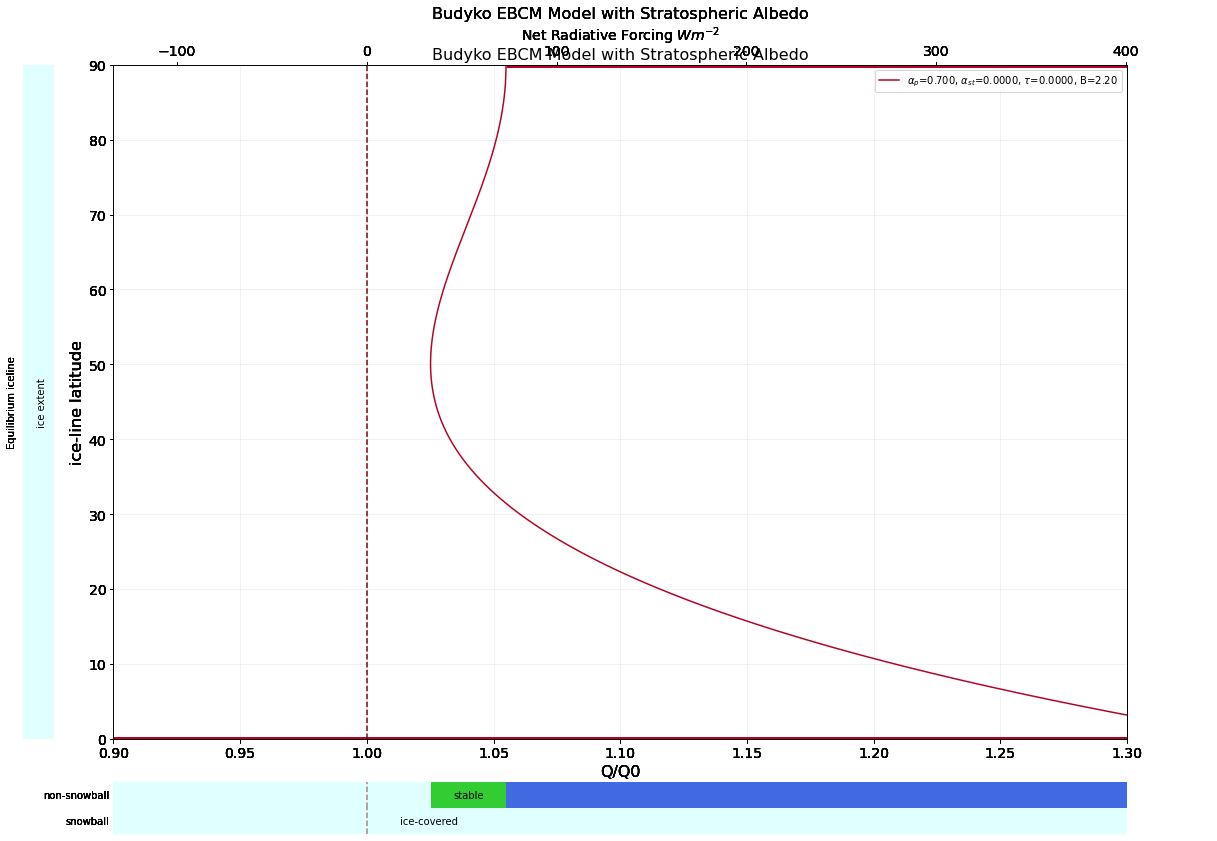

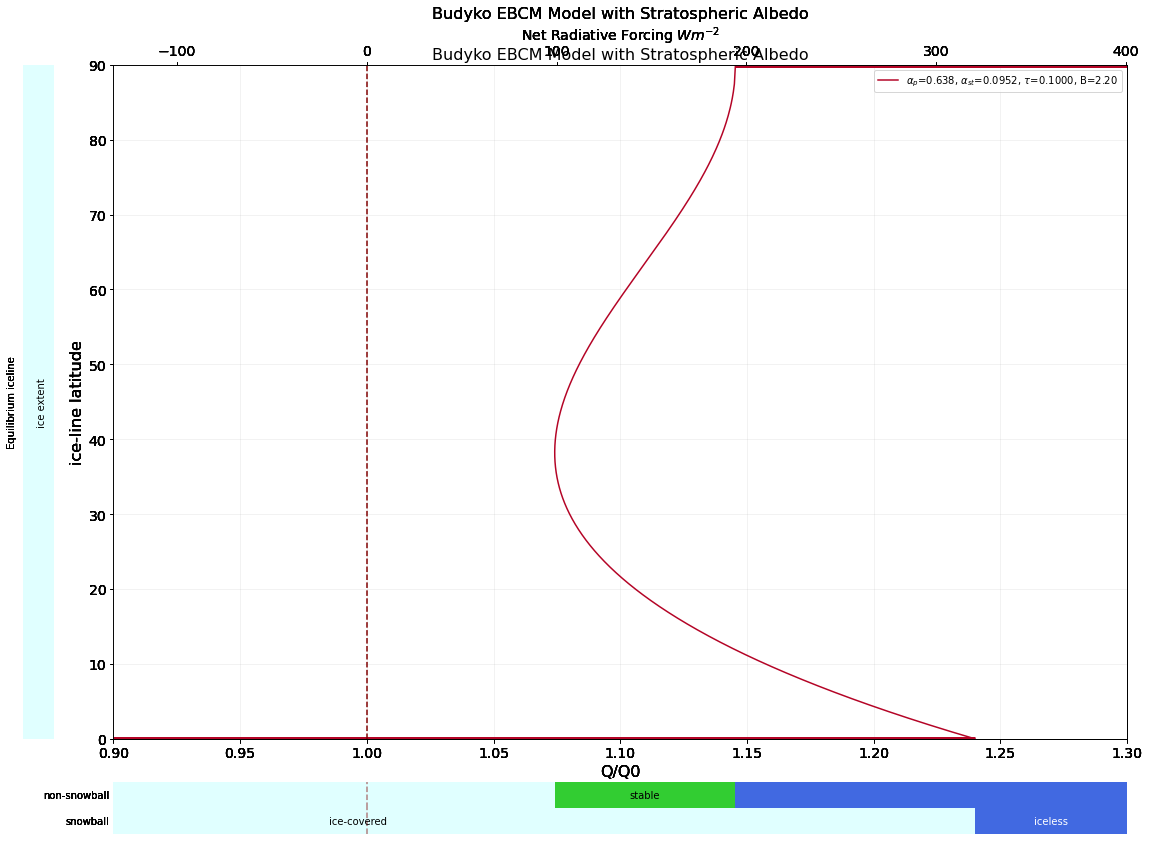

In [3]:
# Inherits the original one above.
class budyko_edit(budyko):
    def plot_timeserie(self, plotname):
        """ plotting function """
        # Shortcuts
        xlim = [0.9,1.3]
        ylim = [0,1]
        self.xlim = xlim
        self.ylim = ylim
        Qrat = self.Qrat

        # MODIFIES the main plot to have multiple axes (bars on sides)
        # setup plot
        plt.figure(figsize=[16,12])
        ax = plt.axes([0.10, 0.13, 0.88, 0.82])

        # main plot
        ax.plot(self.Qrat, self.x, color='black')
        # Vertical lines
        plt.vlines(1,0,ylim[-1], colors = ['maroon'], linestyles='dashed')

        # format plot
        plt.ylabel('sin(ice-line latitude)', fontsize=16)
        self.format_main()
        
        # This calls the sidebars.
        self.x_stability_zones()
        self.y_stability_zones(0)
        return None
    
    def plot_timeserie_lat(self, plotname = None):
        # Shortcuts
        xlim = [0.9,1.3]
        ylim = [0,90]
        self.xlim = xlim
        self.ylim = ylim
        if self.i == 0:
            self.f= plt.figure(figsize=[16,12])
            self.colormap = plt.cm.coolwarm_r
            # If you're starting from a non snowball
            if self.Qrat.min() < 1:
                self.icecovered = False
            else:
            # You're starting from a snowball
                self.icecovered = True
        else:
            # Remove the Sliders
            self.f.axes[3].remove()
            self.f.axes[2].remove()
            self.f.axes[1].remove()
            # setup plot 
        
        # Change icecovered status (Program in the hysteresis)

        # if Qrat0 is below 1, no more snowball equilibrium 
        if self.Qrat[0] < 1:
            # Then return to nonsnowball, and plot as if normal
            self.icecovered = False
        # If gsp is above 1 (on x axis), there is only a snowball equilibrium 
        if self.Qrat.min() > 1:
            self.icecovered = True
        ax = plt.axes([0.10, 0.13, 0.88, 0.78])
        if not self.icecovered:
            # Calculate planetary albedo
            alpha_p = self.alpha_su + self.alpha_strat - self.alpha_su*self.alpha_strat
        else:
            # Just uses the ice-covered albedo since we're ice covered anyway. 
            # Shouldn't make a difference
            alpha_p = self.alpha2 + self.alpha_strat - self.alpha2*self.alpha_strat
        
        # Label for presentation
        # label =r'$\alpha_p$={:.3f}, $\alpha_{{st}}$={:.2f}, $\alpha_2$={:.2f}, $\alpha_1$={:.2f}, B={:.2f}'.format(alpha_p, self.alpha_strat, self.alpha2, self.alpha1, self.B)

        # Label for paper
        # CHoose the variables you change and want to put in the legend. 
        label =r'$\alpha_p$={:.3f}, $\alpha_{{st}}$={:.4f}, $\tau$={:.4f}, B={:.2f}'.format(alpha_p, self.alpha_strat, self.tau, self.B)
        
        # Plot the main line
        ax.plot(self.Qrat, np.rad2deg(np.arcsin(self.x)),color = self.colormap(1-self.i/10), label = label)
        
        # Plot the snowball equilibrium (Horizontal line at 0)
        plt.hlines(0.1,xlim[0], self.Qrat[0], color = self.colormap(1-self.i/10), linewidth = 3)
        # Plot the ice-free equilibrium (Horizontal line at 90deg)
        plt.hlines(89.9,self.Qrat[-1],xlim[1] , color = self.colormap(1-self.i/10), linewidth = 3)
        # Plot the vertical line for equilibrium with incoming radiation. 
        plt.vlines(1,ylim[0],ylim[1] , colors = ['maroon'], linestyles='dashed')
        
        # format plot
        plt.ylabel('ice-line latitude', fontsize=16)
        self.format_main()
        plt.legend(loc = 'upper right')
        # Plot the sideways plots.
        self.x_stability_zones()
        self.y_stability_zones(1) # this includes checking if still in snowball
        
        ax2 = ax.twiny()
        ax2.set_xlim(.9*self.Q0 -self.Q0,1.3*self.Q0 -self.Q0)
        ax2.set_xticks(np.arange(-100, 500, 100))
        plt.xticks(fontsize=14)
        ax2.set_xlabel(r"Net Radiative Forcing $Wm^{-2}$", fontsize = 14)

        plt.savefig('img/{}{}.png'.format(self.series, self.i))
        return None
    
    def format_main(self):
        """
        Puts formatting into a function and renames the original graph. 
        """
        plt.xlabel('Q/Q0',fontsize=16)
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        plt.title('Budyko EBCM Model with Stratospheric Albedo', fontsize=16)  
        plt.grid(which = 'major', alpha = 0.2)
        
    def y_stability_zones(self, deglat = 1):
        """Calculate the iceless and ice-free zones and adds a sidebar"""
        #  Y axis Iceline
        # Add a thin y-axis sidebar. 
        ax_ice = plt.axes([0.02, .13, 0.03, 0.78]) 
        # Overwrite the existing side bar if it exists
        self.remove_lines(ax_ice)
        plt.ylabel('Equilibrium iceline')
        # Set the limits to be the same as the main graph
        ylim = self.ylim
        plt.ylim(ylim)
        # Get the iceline in degrees (not radians)
        ice = self.get_iceline()[deglat]
        # If it is already a snowball and there is an equilibrium at 0 deg, then it stays in a snowball, 
        if self.icecovered and self.Qrat[0] > 1:
            # Stays in snowball, make the whole sidebar ice covered, and just skip the rest of the code
                ax_ice.text(0.5, (ylim[-1])/2, 'ice extent', rotation = 'vertical',ha='center', va='center')
                plt.bar(0, ylim[-1], bottom = 0, color = 'lightcyan', align = 'edge')  
                return 
        # Plot the non-ice covered area. 
        plt.bar(0, ice, color = 'royalblue', align = 'edge')
        # If there is positive ice, add a label
        if ice > 0:
            ax_ice.text(0.5, ice/2, 'land and ocean', color = 'white', rotation = 'vertical',ha='center', va='center')
        # Plot the ice covered area
        plt.bar(0, ylim[-1]-ice, bottom = ice, color = 'lightcyan', align = 'edge')
        # Label the ice-covered area
        ax_ice.text(0.5, (ylim[-1]-ice)/2+ice, 'ice extent', rotation = 'vertical',ha='center', va='center')

    def remove_lines(self, ax):
        # Formatting helper function for matplotlib
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    
    def x_stability_zones(self):
        # Xaxis for a non-snowball setup
        ax_sun = plt.axes([0.10, 0.05, 0.88, 0.03])
        self.remove_lines(ax_sun)
        ax_sun.set_ylabel('non-snowball',position=(0,0.5), rotation ='horizontal', ha = 'right', va = 'center')
        # Calls the 'stable function' that calculates the regions
        self.stable()
        
        # Xaxis for a Snowball, setup
        ax_snowball = plt.axes([0.10, 0.02, 0.88, 0.03])
        self.remove_lines(ax_snowball)
        ax_snowball.set_ylabel('snowball',position=(0,0.5), rotation ='horizontal', ha = 'right', va = 'center')
        # Conditions for stability
        self.snowball()
    
    def stable(self):
        # Shortcutting some self variables for readability
        xlim = self.xlim
        ylim = self.ylim
        Qrat = self.Qrat
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)

        # Extend the maroon vertical line at Q/Q0 = 1 to the sidebars. 
        plt.vlines(1,0,ylim[-1], colors = ['maroon'], linestyles='dashed', alpha = 0.5)
        
        # Calculate and graph Snowball conditions. From a stable equilibrium, 
        # if the sun less powerful (Q/Q0 dropped below the GSP, it would become a snowball)
        plt.barh(0, Qrat.min(),height = ylim[-1], color = 'lightcyan',align = 'edge')
        # Calculate and graph Stable conditions
        # If the 
        plt.barh(0, Qrat[-1]-Qrat.min(),height = ylim[-1], left = Qrat.min(), color = 'limegreen', align = 'edge')
        
        # Label so it doesn't go off the graph with aerosols
        if Qrat[-1] > xlim[-1]:
            stable_max = xlim[-1]
        else: 
            stable_max = Qrat[-1]
        plt.text( Qrat.min() + (stable_max-Qrat.min())/2,ylim[-1]/2, 'stable',ha='center', va='center')
        # Iceless conditions
        plt.barh(0, xlim[-1]-Qrat[-1],height = ylim[-1], left = Qrat[-1], color = 'royalblue', align = 'edge')
        
    def snowball(self):
        # Setup axes
        xlim = self.xlim
        ylim = self.ylim
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
        plt.vlines(1,0,ylim[-1], colors = ['maroon'], linestyles='dashed', alpha = 0.5)

        # Snowball conditions
        plt.barh(0, self.Qrat[0],height = ylim[-1], color = 'lightcyan', label = 'snowball', align = 'edge')
        plt.text(xlim[0]+ (self.Qrat[0]-xlim[0])/4,ylim[-1]/2, 'ice-covered',ha='left', va='center')
        # If the deglaciation point is larger than the energy for an iceless world, 
        # include an iceless region in the snowball in between the two points
        if self.Qrat[0] >self.Qrat[-1]:
            # Iceless conditions
            plt.barh(0, xlim[-1]-self.Qrat[0],height = ylim[-1], left = self.Qrat[0], color = 'royalblue', label = 'iceless', align = 'edge')
            plt.text((xlim[-1]-self.Qrat[0])/2+self.Qrat[0] ,ylim[-1]/2, 'iceless', color = 'white',ha='center', va='center')
        else:      
            # If the iceless ness is above the upper limit for Qrat, then there is a small but stable ice sheet for any energy
            if self.Qrat[-1] > xlim[-1]:
                # Stable goes off the graph
                stable_max = xlim[-1]
            else: 
                # Iceless conditions exist.
                stable_max = self.Qrat[-1]
                plt.text(stable_max + .5*(xlim[-1]-stable_max) ,ylim[-1]/2, 'iceless', color = 'white',ha='center', va='center')
            # Plot the stable and iceless conditions
            # Stable conditions
            plt.barh(0, stable_max-self.Qrat[0],height = ylim[-1], left = self.Qrat[0], color = 'mediumseagreen', label = 'stable', align = 'edge')
            # Iceless conditions
            plt.barh(0, xlim[-1]-self.Qrat[-1],height = ylim[-1], left = self.Qrat[-1], color = 'royalblue', label = 'iceless', align = 'edge')
        
# Testing||
ebcm=budyko_edit(series = 'alpha2_')
for alpha2 in np.linspace(0.6, 0.70, 11):
    x,Q,Qrat,Q0=ebcm.get_qofx(B = 2.2, tau = 0.00, alpha2 = alpha2)
# ebcm=budyko_edit(series = 'alpha1_')
# for alpha1 in np.linspace(0.3, 0.40,11):
#     x,Q,Qrat,Q0=ebcm.get_qofx(B = 2.2, tau = 0.00, alpha1 = alpha1)
ebcm=budyko_edit(series = 'tau_')
for tau in np.linspace(0.0, 0.1,11):
    x,Q,Qrat,Q0=ebcm.get_qofx(B = 2.2, tau = tau)
# ebcm=budyko_edit(series = 'B_')
# for B in np.linspace(2.2, 4.6, 11):
#     x,Q,Qrat,Q0=ebcm.get_qofx(B = B, tau = .1)
# ebcm=budyko_edit(series = 'Bback_')
# for B in np.linspace(4.6, 2.2, 11):
#     x,Q,Qrat,Q0=ebcm.get_qofx(B = B, tau = .1)
# ebcm=budyko_edit(series = 'Bfor_')
# for B in np.linspace(4.6, 2.2, 11)[:6][::-1]:
#     x,Q,Qrat,Q0=ebcm.get_qofx(B = B, tau = .1)

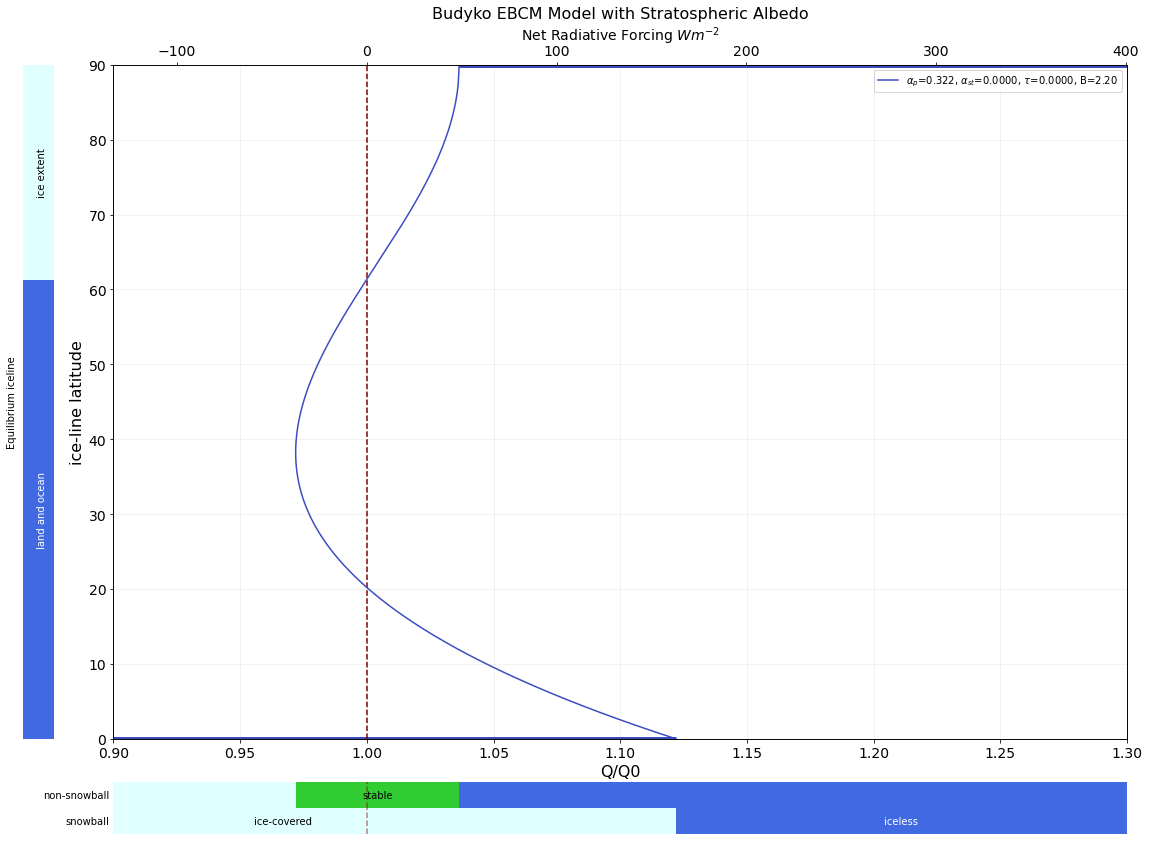

In [4]:
ebcm=budyko_edit(series = 'tau_')
# for tau in np.linspace(0.0, 0.1,11):
x,Q,Qrat,Q0=ebcm.get_qofx(B = 2.2, tau = 0)


In [ ]:
# Search for min constant albedo needed to force out of a snowball
ebcm=budyko_edit(series = 'tau_')
for tau in np.linspace(0.0, 0.1,10):
    x,Q,Qrat,Q0=ebcm.get_qofx( tau = tau)
#     if Qrat.min()>1:
#         break
ebcm.tau

In [ ]:
# Look even closer: Search for min constant albedo needed to force out of a snowball
ebcm=budyko_edit(series = 'tau_')
for tau in np.linspace(0.028, .0290,11):
    x,Q,Qrat,Q0=ebcm.get_qofx(B = 2.2, tau = tau)
    if Qrat.min()>1:
        break
ebcm.tau,ebcm.alpha_strat

In [ ]:
# Look even closer: Search for min constant albedo needed to force out of a snowball
ebcm=budyko_edit(series = 'tau_')
for tau in [0, 0.0127]:
    x,Q,Qrat,Q0=ebcm.get_qofx( tau = tau)
    print()
    print('Tau:', tau, 'B', ebcm.B)
    print("% decrease in Q0 to GSP: {:.4f}".format(1-Qrat.min()))
    print(r"Wm^-2 decrease in Q to GSP: {:.4f}".format((Q-Q0).min()))
    print(r"Wm^-2 decreased absorbed Proportion: {:.4f}".format((Q-Q0).min()/4*(1-ebcm.alpha_strat)))
    print("Deglaciation Q : +{:.4f}%".format((Qrat[0]-1)*100))
    print(r"Deglaciation Q : {:.4f} Wm^-2".format(Q[0]-Q0))
    if tau == 0:
        a = Q[0]-Q0
Q[0]-Q0 - a

In [ ]:
# Look even closer: Search for min constant albedo needed to force out of a snowball
ebcm=budyko_edit(series = 'tau_')
for tau in [0, 0.0285]:
    x,Q,Qrat,Q0=ebcm.get_qofx(B = 2.2, tau = tau)
    print()
    print('Tau:', tau, 'B', ebcm.B)
    print("% decrease in Q0 to GSP: {:.4f}".format(1-Qrat.min()))
    print(r"Wm^-2 decrease in Q to GSP: {:.4f}".format((Q-Q0).min()))
    print(r"Wm^-2 decreased absorbed Proportion: {:.4f}".format((Q-Q0).min()/4*(1-ebcm.alpha_strat)))
    print("Deglaciation Q : +{:.4f}%".format((Qrat[0]-1)*100))
    print(r"Deglaciation Q : {:.4f} Wm^-2".format(Q[0]-Q0))
    if tau == 0:
        a = Q[0]-Q0
Q[0]-Q0 - a

In [ ]:
1/(2*(1-np.exp(-2/3)))

In [ ]:
.1/(2*(1-np.exp(-2/4)))

In [ ]:
1/(-2*np.log(1- 0.0127/.8))

In [ ]:
1/(-2*np.log(1- 0.0285/.8))

In [ ]:
t = np.array(np.linspace(0,31.2*2,10000))
.4*np.exp(-t/2).mean()

In [ ]:
t = np.array(np.linspace(0,13.7*2,100))
.4*np.exp(-t/2).mean()

In [ ]:
43.3/162.9

In [ ]:
ebcm=budyko_edit(series = 'test_')
A=211.1
B=1.55
for factor in np.linspace(1,0.7, 11):
    x,Q,Qrat,Q0=ebcm.get_qofx(A = factor* A, B = factor*B, tau = .1)
    


# Random notes and tests

In [ ]:
## info = (t, 0, Q0)
# Get a new plot
lines, = plt.plot(SaveRun[-1,:], np.rad2deg(np.arcsin(x)), ls = '--', color = colormap(.99), label = 't={:>4}, [$SO_2$]={} Mt, $Q_{{trans}}$={} $Wm^{{-2}}$'.format(*info))
# Append it to lab
lab.append(lines)
plt.legend(handles=lab,loc = 'upper right')
plt.savefig("img/t{}.png".format('-e'))

color_idx = np.linspace(0, 1, len(timesteps))
for t in timesteps:
    qbar = optical_flux(1336, taus[t])
    info = (halflives[t], round(so2[t],4), round(optical_flux(1336, taus[t]),1))
    lines, = plt.plot(SaveRun[t,:], np.rad2deg(np.arcsin(x)), color=colormap(color_idx[t]), label = 't={:4d}d, [$SO_2$]={:4.3f} Mt, $Q_{{trans}}$={} $Wm^{{-2}}$'.format(*info))
    lab.append(lines)
    plt.legend(handles=lab, loc = 'upper right')
    plt.savefig("img/t{}.png".format(t))

In [ ]:

#half-life 
halflife_so2 = 30 # 21-28 days to h2so4 aersols, 33 is averaged for unoxidized pathways pathways also
# https://pubs.usgs.gov/pinatubo/self/
pinatubo_so2 = 20 # Megatons 
n = 12
# Parameterize different scenarios
timesteps = np.arange(0, 12)
halflives = timesteps*halflife_so2
decay = (1/(2**timesteps)) 
so2 = pinatubo_so2*decay # Mt
taus = tau_bar*decay # Optical depth
halflives, taus, optical_flux(1336, taus)

In [ ]:
# Stratospheric Albedo
1-np.exp(-np.linspace(0,0.2))
# Planetary Absorptivity = (1- alpha surface (1- alpha_statosphere)

In [ ]:
# Question 2
ebcm=budyko(tau = 0.1)
print(ebcm.etau)
x,Q,Qrat,Q0=ebcm.get_qofx(plotname = 'q2')
# Question 3
# Call get_roots to get eq sols (in sin x and degrees) for Q = 1
iceline,j =ebcm.get_roots()
# Find minimum Q, GSP
x_gsp,x_gsp_deg=ebcm.find_gsp()
# Question 4 (after increasing linspace spacing)
Qrat[np.degrees(np.arcsin(x)).searchsorted(85)]